In [2]:
#!pip install pyportfolioopt

In [3]:
import yfinance as yf
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

%matplotlib inline

In [4]:
# data = pd.read_csv('nyse_data.csv')
# data = data.drop(['Last Sale', 'Net Change', '% Change', 'Market Cap', 'IPO Year', 'Volume'], axis = 1)
# data = data.dropna().reset_index().drop(['index'], axis = 1)

start = '2018-01-01'
end = '2018-12-31'
# stocks = dict()
# symbols = list(data['Symbol'])
# stock_data = yf.download(symbols, start=start, end=end).dropna(axis = 1).drop(columns = ['Adj Close','High','Low','Open'])

# stock_data['Close'].to_csv('prices_2018.csv', index=True)
# stock_data['Volume'].to_csv('volumes_2018.csv', index=True)


In [5]:
data = pd.read_csv('nyse_data.csv')
prices = pd.read_csv('prices_2018.csv')
volumes = pd.read_csv('volumes_2018.csv')

###1. Efficient frontier ###
####Выбрать на рынке набор из 50 акций.  Объясните ваш выбор. Построить эффективный фронт портфелей инвестиций без ограничений на короткие позиции и  эффективный фронт с запретом коротких позиций. Сравнить эффективные фронты и сделать выводы.  При построении эффективных фронтов вычислить портфели с минимальным риском и отметить их на соответствующем эффективном фронте. Рассмотреть портфель с равными долями вложения капитала и оценить, как  далек этот портфель от эффективного фронта. Тот же вопрос для индекса рынка.####


Возьмем 50 компаний с наибольшей капитализацией из индекса NYSE US 100. Индекс измеряет показатели 100 крупнейших компаний США, торгуемые на Нью-Йоркской фондовой бирже.

In [6]:
comp_50 = pd.read_excel('50_comp_nyse.xlsx', ).drop(['index'], axis = 1)
comp_50 = list(comp_50.Symbol)

In [7]:
log_profitability_stocks = prices[list(prices.columns)[1:]].copy()
for symbol in list(prices.columns)[1:]:
    log_profitability_stocks[symbol] = np.log(prices[symbol] / prices[symbol].shift(1))
log_profitability_stocks = log_profitability_stocks.drop(index = log_profitability_stocks.index[0])

In [8]:
names = list(log_profitability_stocks.columns)
stock_prop = pd.DataFrame(columns = ['E','Sigma'], index = names)
for i in range(len(names)):
    E = log_profitability_stocks[names[i]].mean()
    Sigma = log_profitability_stocks[names[i]].std()
    stock_prop.iloc[i,0] = E
    stock_prop.iloc[i,1] = Sigma

In [9]:
cov_matrix = log_profitability_stocks.cov()
profit = stock_prop['E']
cov_matrix_50 = log_profitability_stocks[comp_50].cov()
profit_50 = stock_prop['E'][comp_50]

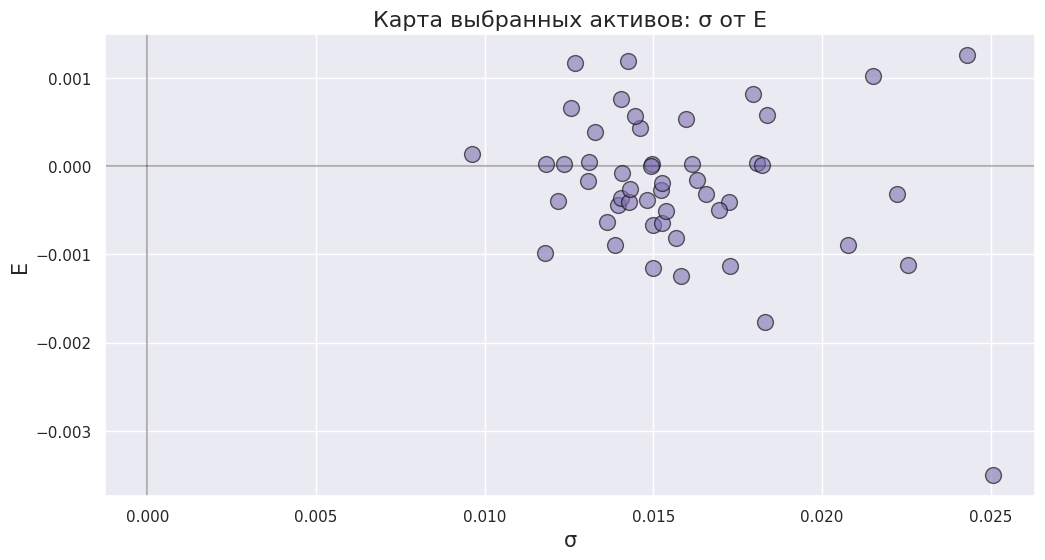

In [10]:
sns.set()
plt.figure(figsize=(12,6))

plt.axhline(y=0, color='k', alpha=0.3)
plt.axvline(x=0, color='k', alpha=0.3)
plt.scatter(stock_prop['Sigma'][comp_50], profit_50, s=130, c='m',
            edgecolor='black', alpha=0.6)

plt.xlabel('σ', size=15)
plt.ylabel('E', size=15)
plt.title("Карта выбранных активов: σ от E", size=16)
pass

Характеристика портфеля без коротких продаж:

Expected annual return: -0.0%
Annual volatility: 0.7%
Sharpe Ratio: -2.71
(-0.0003064681392684684, 0.007499436433845259, -2.707732550091972) 

Доли в портфеле с минимальной дисперсией:
{'LLY': 0.0, 'TSM': 0.0, 'V': 0.0, 'NVO': 0.05932, 'JPM': 0.0, 'WMT': 0.0, 'MA': 0.0, 'UNH': 0.0, 'XOM': 0.0, 'JNJ': 0.0, 'HD': 0.0, 'PG': 0.04846, 'TM': 0.11712, 'MRK': 0.0, 'ABBV': 0.0, 'ORCL': 0.0, 'CRM': 0.0, 'BAC': 0.0, 'CVX': 0.0, 'KO': 0.34895, 'ACN': 0.0, 'FMX': 0.00171, 'TMO': 0.0, 'SAP': 0.0, 'MCD': 0.0855, 'NVS': 0.01167, 'DIS': 0.0, 'ABT': 0.0, 'SHEL': 0.04245, 'WFC': 0.0, 'DHR': 0.0, 'BABA': 0.0, 'IBM': 0.0, 'GE': 0.01165, 'CAT': 0.0, 'AXP': 0.0, 'UNP': 0.0, 'NOW': 0.0, 'BX': 0.00052, 'TTE': 0.0, 'NKE': 0.0, 'HSBC': 0.18224, 'BHP': 0.0, 'MS': 0.0, 'PFE': 0.0, 'PM': 0.01797, 'LOW': 0.0, 'HDB': 0.07243, 'SYK': 0.0, 'SPGI': 0.0}


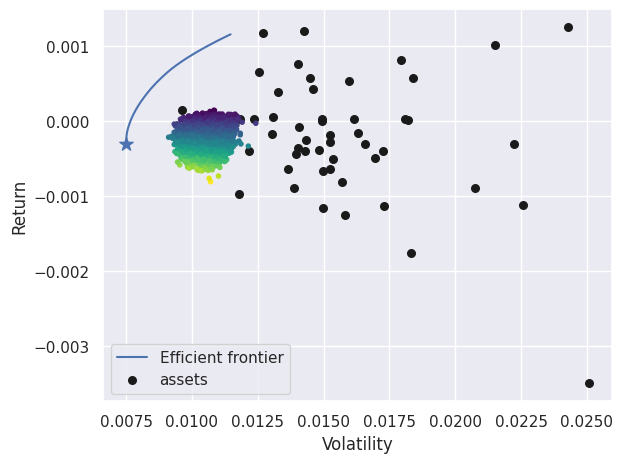

In [11]:
ef_long = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(0,1))
fig, ax = plt.subplots()
pplt.plot_efficient_frontier(ef_long, ax=ax, show_assets=True)

ef_long = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(0,1))
ef_long.min_volatility()
minvol_pwt=ef_long.clean_weights()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(profit_50)), n_samples)
rets = w.dot(profit_50)
stds = np.sqrt(np.diag(w @ cov_matrix_50 @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ret_min, std_min, _ = ef_long.portfolio_performance()
ax.scatter(std_min, ret_min, marker="*", s=100, c="b", label="Min Risk")

print(ef_long.portfolio_performance(verbose=True), '\n')
print('Доли в портфеле с минимальной дисперсией:')
print(dict(minvol_pwt))

pass

Характеристика портфеля с короткими продажами:

Expected annual return: -0.0%
Annual volatility: 0.6%
Sharpe Ratio: -3.22
(-9.142280935710703e-05, 0.006246496426216148, -3.216430689855946) 

Доли в портфеле с минимальной дисперсией:
{'LLY': 0.05504, 'TSM': -0.00542, 'V': -0.02634, 'NVO': 0.07209, 'JPM': 0.26215, 'WMT': 0.03345, 'MA': 0.05574, 'UNH': -0.02269, 'XOM': 0.00585, 'JNJ': -0.02586, 'HD': -0.0524, 'PG': 0.03862, 'TM': 0.2282, 'MRK': -0.13339, 'ABBV': -0.01574, 'ORCL': -0.08409, 'CRM': 0.06024, 'BAC': -0.02189, 'CVX': -0.06938, 'KO': 0.44215, 'ACN': -0.05958, 'FMX': -0.00493, 'TMO': -0.06638, 'SAP': 0.04931, 'MCD': 0.07454, 'NVS': 0.04084, 'DIS': 0.03569, 'ABT': 0.05187, 'SHEL': 0.17762, 'WFC': -0.00942, 'DHR': 0.10251, 'BABA': -0.02103, 'IBM': -0.0548, 'GE': 0.04104, 'CAT': -0.08122, 'AXP': -0.11475, 'UNP': 0.04843, 'NOW': 0.00073, 'BX': 0.08542, 'TTE': -0.03668, 'NKE': -0.05178, 'HSBC': 0.24547, 'BHP': -0.06849, 'MS': -0.27049, 'PFE': -0.01161, 'PM': -0.00794, 'LOW': -0.01634, 'HDB': 0.10628, 'SYK': 0.0552, 'SPGI': -0.0358

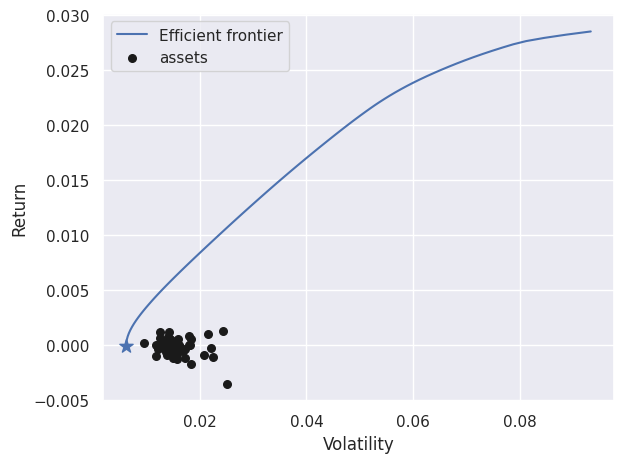

In [12]:
ef_short = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(-1,1))
fig, ax = plt.subplots()
pplt.plot_efficient_frontier(ef_short, ax=ax, show_assets=True)

ef_short = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(-1,1))
ef_short.min_volatility()
minvol_pwt=ef_short.clean_weights()

ret_min, std_min, _ = ef_short.portfolio_performance()
ax.scatter(std_min, ret_min, marker="*", s=100, c="b", label="Min Risk")

print(ef_short.portfolio_performance(verbose=True), '\n')
print('Доли в портфеле с минимальной дисперсией:')
print(dict(minvol_pwt))

pass

In [13]:
nus_index = yf.download('NUS', start=start, end=end)
nus_index = nus_index.drop(columns = ['Open', 'High', 'Low', 'Adj Close'])


[*********************100%%**********************]  1 of 1 completed


In [14]:
log_profitability_nus_index = nus_index['Close'].copy()
for j in range(prices.shape[0]):
    log_profitability_nus_index[j] = math.log(nus_index['Close'][j]/nus_index['Close'][j-1])
log_profitability_nus_index.iloc[0] = 0

nus_E = log_profitability_nus_index.mean()
nus_S = log_profitability_nus_index.std()

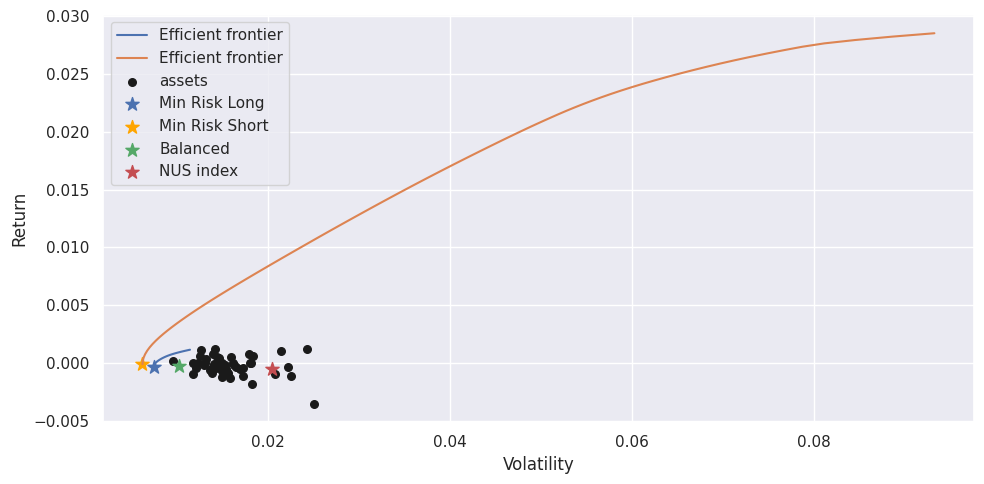

In [15]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

ef_long = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(0,1))
pplt.plot_efficient_frontier(ef_long, ax=ax, show_assets=False)

ef_short = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(-1,1))
pplt.plot_efficient_frontier(ef_short, ax=ax, show_assets=True)

ef_long = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(0,1))
ef_long.min_volatility()
ret_min, std_min, _ = ef_long.portfolio_performance()
ax.scatter(std_min, ret_min, marker="*", s=100, c="b", label="Min Risk Long")

ef_short = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(-1,1))
ef_short.min_volatility()
ret_min, std_min, _ = ef_short.portfolio_performance()
ax.scatter(std_min, ret_min, marker="*", s=100, c="orange", label="Min Risk Short")

ef_short = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(1/50,1/50))
ef_short.min_volatility()

ret_min, std_min, _ = ef_short.portfolio_performance()
ax.scatter(std_min, ret_min, marker="*", s=100, c="g", label="Balanced")

ax.scatter(nus_S, nus_E, marker="*", s=100, c="r", label="NUS index")
ax.legend()

pass

Вывод: Можно заметить, что практически при равной доходности портфель с минимальным риском без коротких продаж менее рисковый, чем с коротким. Также риск намного выше у сбалансированного портфеля и индекса рынка при схожей доходности. Как и ожидалось, эффективный фронт с запрещенными продажами оказался ниже эффективного фронта без ограничений.

###2. Portfolio selection problem. ###
####Требуется построить «хорошие» инвестиционные портфели из 10 активов вместо исходных 50 (или даже всех активов рынка). Предложите способ выбрать 10 активов (из отобранных ранее 50) для формирования портфеля. Сравните эффективные фронты всего набора (50 акций) и выбранного набора активов (10 акций) для двух случаев: короткие продажи разрешены,короткие продажи запрещены.####

Мы решили взять 10 акций из всех активов рынка со значениями весов портфеля с максимальным коэффициентом Шарпа.

In [16]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255
rf =0.01
sharpes = log_profitability_stocks[comp_50].apply(sharpe_ratio, args=(N,rf,), axis=0 )
sharpes_10 = list(sharpes.sort_values()[-10:].index)


In [17]:
cov_matrix_10 = log_profitability_stocks[sharpes_10].cov()
profit_10 = profit[sharpes_10]

Эффективные фронты с ограничениями продаж:

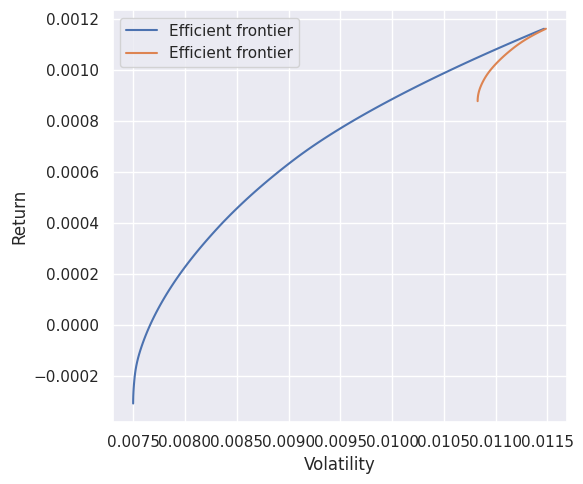

In [18]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(6)

ef_long_50 = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(0,1))
pplt.plot_efficient_frontier(ef_long_50, ax=ax, show_assets=False)

ef_long_10 = EfficientFrontier(profit_10, cov_matrix_10, weight_bounds=(0,1))
pplt.plot_efficient_frontier(ef_long_10, ax=ax, show_assets=False )

pass

Эффективные фронты без ограничения продаж:

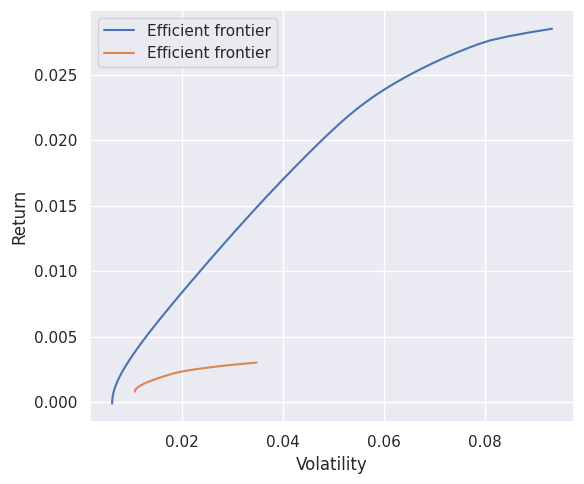

In [19]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(6)

ef_short_50 = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(-1,1))
pplt.plot_efficient_frontier(ef_short_50, ax=ax, show_assets=False)

ef_short_10 = EfficientFrontier(profit_10, cov_matrix_10, weight_bounds=(-1,1))
pplt.plot_efficient_frontier(ef_short_10, ax=ax, show_assets=False)

pass

Сравнение:

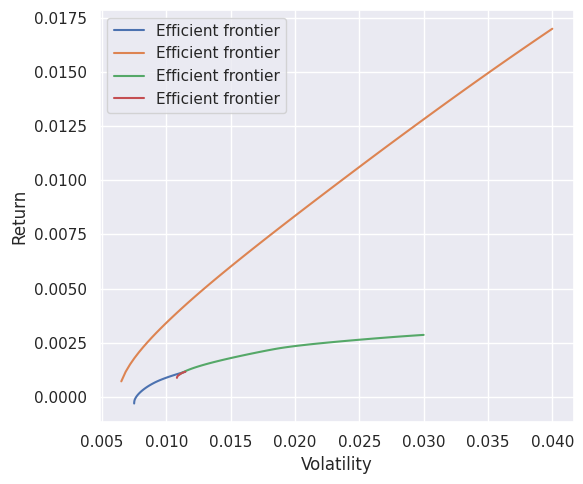

In [20]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(6)

ef_long_50 = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(0,1))
pplt.plot_efficient_frontier(ef_long_50, ax=ax, show_assets=False)

ef_short_50 = EfficientFrontier(profit_50, cov_matrix_50, weight_bounds=(-1,1))
pplt.plot_efficient_frontier(ef_short_50, ax=ax, show_assets=False, ef_param='risk', ef_param_range=np.linspace(0.0065, 0.04, 100))

ef_short_10 = EfficientFrontier(profit_10, cov_matrix_10, weight_bounds=(-1,1))
pplt.plot_efficient_frontier(ef_short_10, ax=ax, show_assets=False, ef_param='risk', ef_param_range=np.linspace(0.011, 0.03, 100))

ef_long_10 = EfficientFrontier(profit_10, cov_matrix_10, weight_bounds=(0,1))
pplt.plot_efficient_frontier(ef_long_10, ax=ax, show_assets=False )

# plt.legend()
plt.show()

* Желтая: эффективный фронт (50)
* Синяя: эффективный фронт без коротких продаж (50)
* Красная: эффективный фронт без коротких продаж (10)
* Зеленая: эффективный фронт (10)

Вывод: В случае с разрешенными короткими продажами выгоднее всего брать портфель с 50 акциями, так как у него при равном уровне риска выше доходность. Такая же ситауция наблюдается и при их ограничении.

###3. Risk aversion.###
####Оцените свое отношение к риску и постройте свой личный оптимальный портфель инвестиций из выбранных 50 активов. Дайте характеристику портфеля по составу и долям активов. Оцените VaR доходностей портфеля. Рассмотрите два случая: короткие продажи разрешены, короткие продажи запрещены.

In [21]:
def obj_func(X, returns, alpha, cov_matr):
    return - np.dot(returns, X) + alpha * float(np.matmul(np.matmul(X, cov_matr.to_numpy()), X.T))
def get_portfolio_with_min_risk(obj_func, returns, cov_matr, alpha, bounds, tick_num):
    X = np.ones(tick_num)
    X = X/X.sum()
    bounds = bounds*tick_num

    constraints = []
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})

    return minimize(obj_func, X,
                    args=(returns, alpha, cov_matr), method='SLSQP', #МНК
                    #constraints=constraints,
                    bounds=bounds).x

In [22]:
def risk_aversion(dist, alpha):
    tick_num = len(comp_50)
    E = profit_50.values
    returns = log_profitability_stocks[comp_50]
    bounds = ((-1, 1),) if dist=='short' else ((0, 1),)

    portfolio_weights = get_portfolio_with_min_risk(obj_func, E, cov_matrix_50, alpha, bounds, tick_num)

    min_std = float(np.matmul(np.matmul(portfolio_weights, cov_matrix_50.to_numpy()), portfolio_weights.T))
    min_E = np.dot(portfolio_weights, E)
    losses = - np.dot(returns, portfolio_weights)
    return min_std, min_E, losses, portfolio_weights

In [23]:
std1, E1, losses1, X1 = risk_aversion(dist='short', alpha=1)
std2, E2, losses2, X2 = risk_aversion(dist='short', alpha=2)
std3, E3, losses3, X3 = risk_aversion(dist='short', alpha=3)
std4, E4, losses4, X4 = risk_aversion(dist='short', alpha=4)
std5, E5, losses5, X5 = risk_aversion(dist='short', alpha=5)

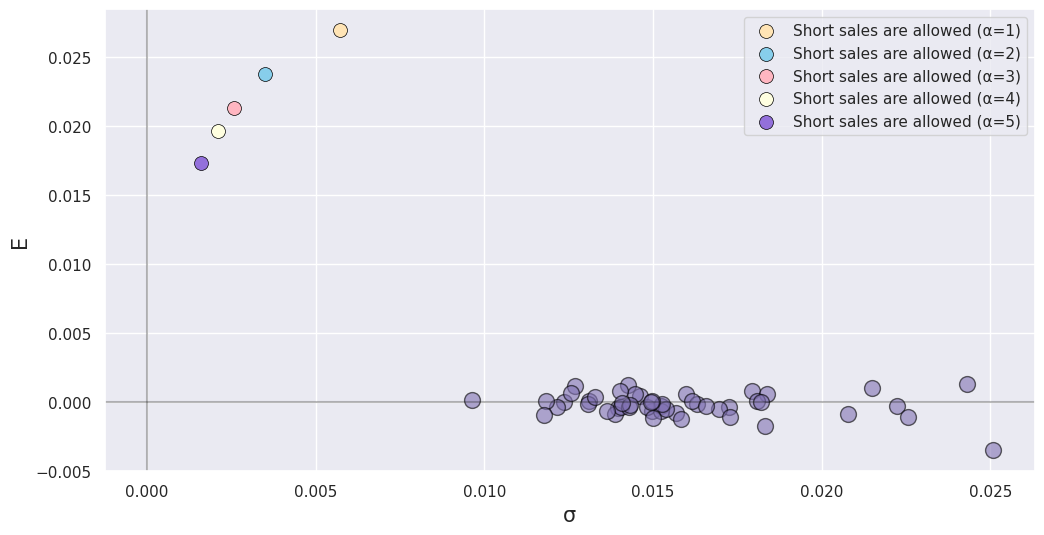

In [24]:
sns.set()
plt.figure(figsize=(12,6))

plt.axhline(y=0, color='k', alpha=0.3)
plt.axvline(x=0, color='k', alpha=0.3)
plt.scatter(stock_prop['Sigma'][comp_50], profit_50, s=130, c='m',
            edgecolor='black', alpha=0.6)

plt.xlabel('σ', size=15)
plt.ylabel('E', size=15)

plt.scatter(std1, E1, marker="o", color='moccasin',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=1)")
plt.scatter(std2, E2, marker="o", color='skyblue',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=2)")
plt.scatter(std3, E3, marker="o", color='lightpink',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=3)")
plt.scatter(std4, E4, marker="o", color='lightyellow',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=4)")
plt.scatter(std5, E5, marker="o", color='mediumpurple',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=5)")

plt.legend()
fig.show()

Как видно по графику, портфель с отношением к риску α=5 имеет самый низкий показатель стандартного отклонения. Поэтому этот портфель с наибольшим успехом диверсифицирует риск.

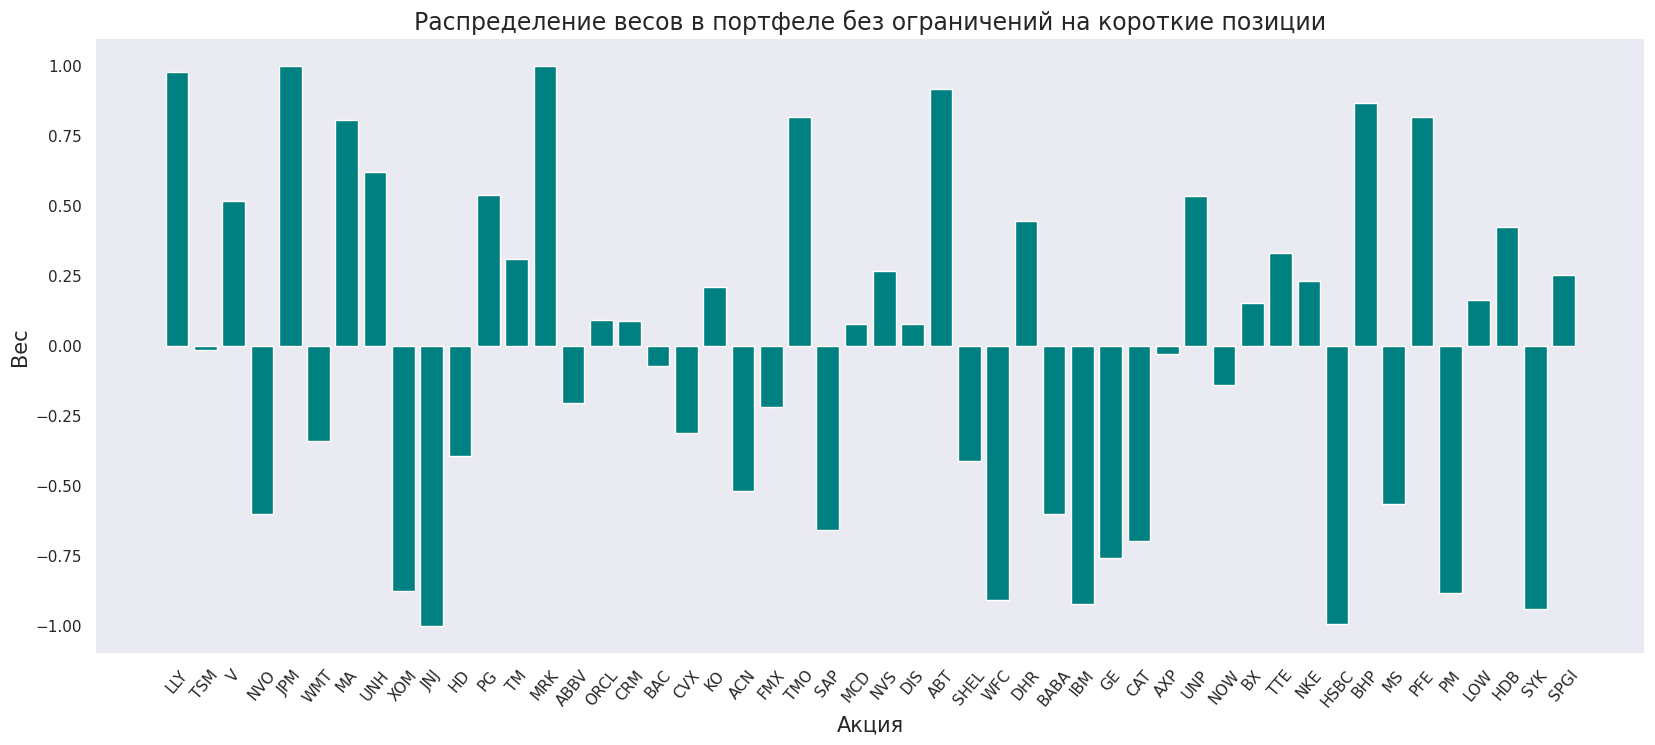

In [25]:
min_std1, min_E1, losses1, portfolio_weights1 = risk_aversion(dist='short', alpha=5)

weights_data = pd.DataFrame(index = comp_50, columns = ['weight'])
weights_data['weight'] = portfolio_weights1

plt.figure(figsize = (20,8))
x = np.arange(weights_data.shape[0])
x_values = weights_data.index
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(x, height = weights_data['weight'], color="teal")
plt.xticks(x, x_values, rotation=50)
plt.title("Распределение весов в портфеле без ограничений на короткие позиции", fontsize = 17)
plt.grid()

In [26]:
weights_data.sort_values(by='weight', key=abs)[:5]

,weight
TSM,-0.012015
AXP,-0.026006
BAC,-0.071378
MCD,0.081287
DIS,0.081398


Компаний, которые имеют меньший вес:
* Taiwan Semiconductor Manufacturing Company Limited - Semiconductors
* American Express Company - Credit Services
* Bank of America Corporation - Banks-Diversified
* McDonald's Corporation - Restaurants
* The Walt Disney Company - Entertainment

In [27]:
weights_data.sort_values(by='weight', key=abs)[-5:]

,weight
LLY,0.981368
HSBC,-0.991510
JPM,1.000000
MRK,1.000000
JNJ,-1.000000


Компании, которые имеют наибольший вес:
* Johnson & Johnson - Drug Manufacturers
* Merck & Co., Inc. - Drug Manufacturers
* JPMorgan Chase & Co - Banks - Diversified
* HSBC Holdings plc - Banks-Diversified
* Eli Lilly and Company - Drug Manufacturers


Из полученных результатов сложно сделать какой-то определеный вывод (получились разные сферы), однако в портфеле предпочтение отдется компаниям из сектора здравоохранения.

In [28]:
сonfidence_levels = [0.9, 0.95, 0.99]
VaR = {}

print('VaR для портфеля с отношением к риску α=5 с запретом на короткие продажи:')

for level in сonfidence_levels:
    VaR[level] = np.quantile(losses1, level)
    print('- Потери не превысят %.5f с уверенностью %.f%s.' % (np.round(VaR[level],5), level*100, '%'))

VaR для портфеля с отношением к риску α=5 с запретом на короткие продажи:
- Потери не превысят 0.03029 с уверенностью 90%.
- Потери не превысят 0.04491 с уверенностью 95%.
- Потери не превысят 0.06565 с уверенностью 99%.


Теперь для коротких продаж

In [29]:
std11, E11, losses11, X11 = risk_aversion(dist='short_sales_are_not_allowed', alpha=1)
std22, E22, losses22, X22 = risk_aversion(dist='short_sales_are_not_allowed', alpha=2)
std33, E33, losses33, X33 = risk_aversion(dist='short_sales_are_not_allowed', alpha=3)
std44, E44, losses44, X44 = risk_aversion(dist='short_sales_are_not_allowed', alpha=4)
std55, E55, losses55, X55 = risk_aversion(dist='short_sales_are_not_allowed', alpha=5)

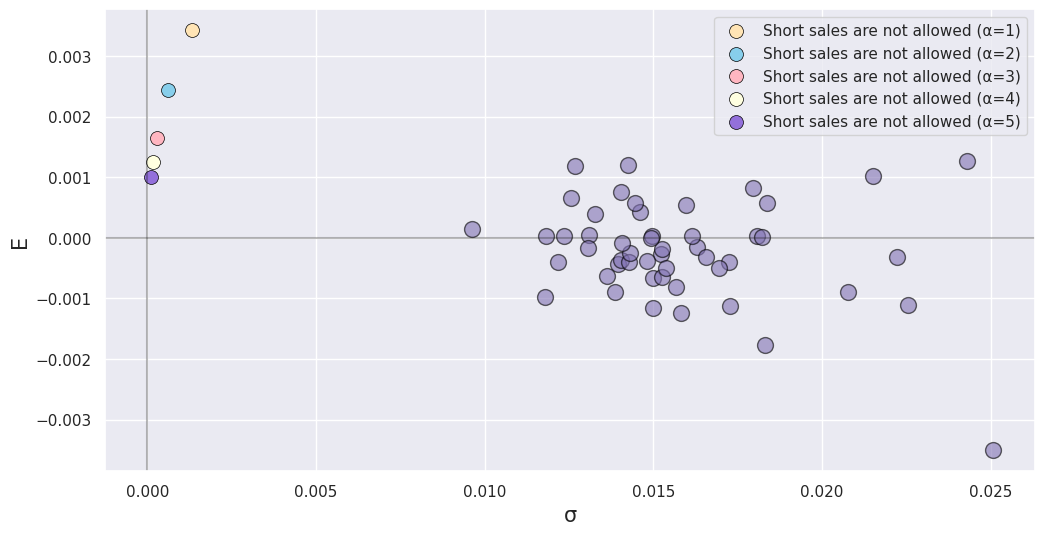

In [30]:
sns.set()
plt.figure(figsize=(12,6))

plt.axhline(y=0, color='k', alpha=0.3)
plt.axvline(x=0, color='k', alpha=0.3)
plt.scatter(stock_prop['Sigma'][comp_50], profit_50, s=130, c='m',
            edgecolor='black', alpha=0.6)

plt.xlabel('σ', size=15)
plt.ylabel('E', size=15)

plt.scatter(std11, E11, marker="o", color='moccasin',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=1)")
plt.scatter(std22, E22, marker="o", color='skyblue',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=2)")
plt.scatter(std33, E33, marker="o", color='lightpink',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=3)")
plt.scatter(std44, E44, marker="o", color='lightyellow',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=4)")
plt.scatter(std55, E55, marker="o", color='mediumpurple',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=5)")

plt.legend()
fig.show()

Самое низкое стандартное отклонение имеет портфель, построенный с отношением к риску α=5. Визуализируем распределение весов между компаниями в этом портфеле:

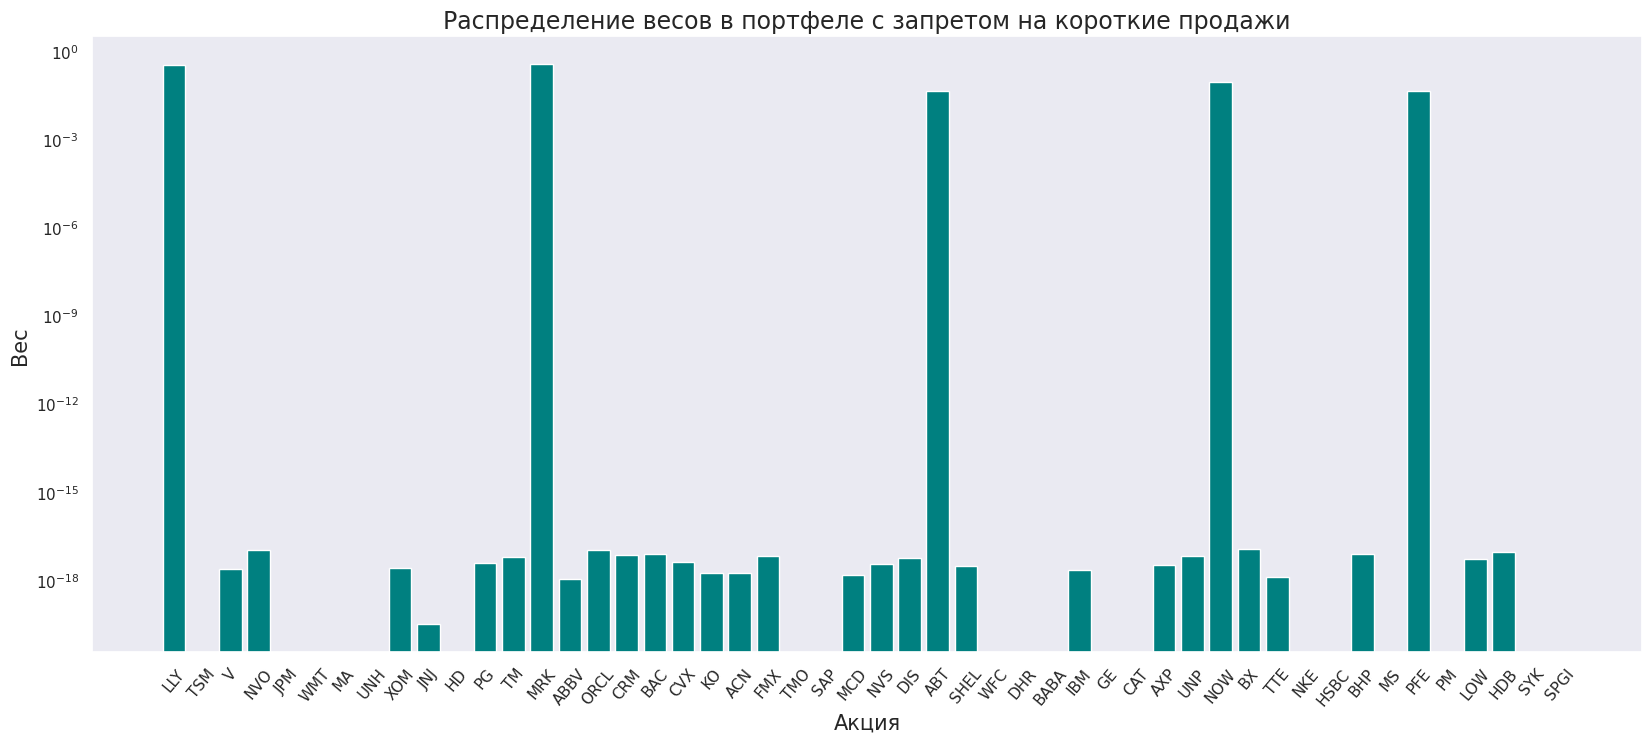

In [31]:
min_std2, min_E2, losses2, portfolio_weights2 = risk_aversion(dist='short_sales_are_not_allowed', alpha=5)

weights_data1 = pd.DataFrame(index = comp_50, columns = ['weight'])
weights_data1['weight'] = portfolio_weights2

plt.figure(figsize = (20,8))
x = np.arange(weights_data1.shape[0])
x_values = weights_data1.index
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(x, height = weights_data1['weight'], color='teal')
plt.xticks(x, x_values, rotation=50)
plt.yscale("log")
plt.title("Распределение весов в портфеле с запретом на короткие продажи", fontsize = 17)
plt.grid()

In [32]:
len(weights_data1[weights_data1['weight'] == 0])

19

In [33]:
weights_data1.sort_values(by='weight')[-5:]

,weight
ABT,0.043570
PFE,0.045818
NOW,0.086559
LLY,0.337932
MRK,0.358015


Компании, которые имеют наибольший вес:
* Merck & Co., Inc. - Drug Manufacturers
* Eli Lilly and Company - Drug Manufacturers
* ServiceNow, Inc. - Digital Services
* Pfizer Inc. - Drug Manufacturers
* Abbott Laboratories - Medical Devices

В случае с ограничением на короткие продажи в портфель не попало 19 активов. Предпочтение снова отдавалось сфере здравоохранения (все топ 5 компаний).

In [34]:
сonfidence_levels = [0.9, 0.95, 0.99]
VaR = {}

print('VaR для портфеля с отношением к риску α=5 с запретом на короткие продажи:')

for level in сonfidence_levels:
    VaR[level] = np.quantile(losses2, level)
    print('- Потери не превысят %.5f с уверенностью %.f%s.' % (np.round(VaR[level],5), level*100, '%'))

VaR для портфеля с отношением к риску α=5 с запретом на короткие продажи:
- Потери не превысят 0.01099 с уверенностью 90%.
- Потери не превысят 0.01682 с уверенностью 95%.
- Потери не превысят 0.02853 с уверенностью 99%.


Можем отметить, что в портфеле с запретом на короткие продажи потери имеют гораздо меньшее значение по сравнению с портфелем с разрешёнными короткими продажами

###4. Markowitz-Tobin model.
####Рассмотрите набор активов, отобранных в п.2 (10 активов).  Выберете  безрисковый актив (можно виртуальный). Постройте рыночный (оптимальный)  портфель. Сделайте анализ долей активов рыночного портфеля. Оцените VaR доходностей портфеля. Рассмотрите два случая: короткие продажи разрешены, короткие продажи запрещены.

In [35]:
std_10 = pd.DataFrame(data= pd.DataFrame(stock_prop['Sigma'],
                                columns = ['Sigma'],
                                index = sharpes_10))
#10 компаний, выбранных с помощью коэффициента Шарпа в п.2.
std_10

,Sigma
NKE,0.018377
V,0.015983
TMO,0.014471
MA,0.017946
CRM,0.021502
PFE,0.012551
NOW,0.0243
ABT,0.01403
LLY,0.014257
MRK,0.012683


Можем наблюдать, что у рассматриваемых нами активов среднеквадратичные отклонения имеют существенные значения, поэтому создадим виртуальный актив со средней доходностью 0.0001

In [36]:
free_risk = 0.0001

In [37]:
def obj_func(X, returns, risk_free_mean, cov_matr):
    return float(-(X.dot(returns) - risk_free_mean) / np.sqrt(np.dot(np.dot(X, cov_matr), X.T)))

def get_portfolio_sharp_ratio(obj_func, returns, cov_matr, risk_free_mean, bounds, tick_num):
    X = np.ones(tick_num)
    X = X/X.sum()
    bounds = bounds*tick_num

    constraints = []
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})

    return minimize(obj_func, X,
                    args=(returns, risk_free_mean, cov_matr), method='SLSQP', #МНК
                    constraints=constraints,
                    bounds=bounds).x

In [38]:
def sharp_optimal_portfolio(dist, risk_free_mean, tickers10, returns, profit10, cov ):
    tick_num = len(tickers10)
    E = profit10
    #returns = log_pr
    bounds = ((-1, 1),) if dist=='short' else ((0, 1),)

    portfolio_weights = get_portfolio_sharp_ratio(obj_func, E, cov, risk_free_mean, bounds, tick_num)

    min_std = float(np.matmul(np.matmul(portfolio_weights, cov.to_numpy()), portfolio_weights.T))
    min_E = np.dot(portfolio_weights, E)
    losses = - np.dot(returns, portfolio_weights)
    return min_std, min_E, losses, portfolio_weights

V MRK LLY PFE MA NOW TMO CRM ABT NKE


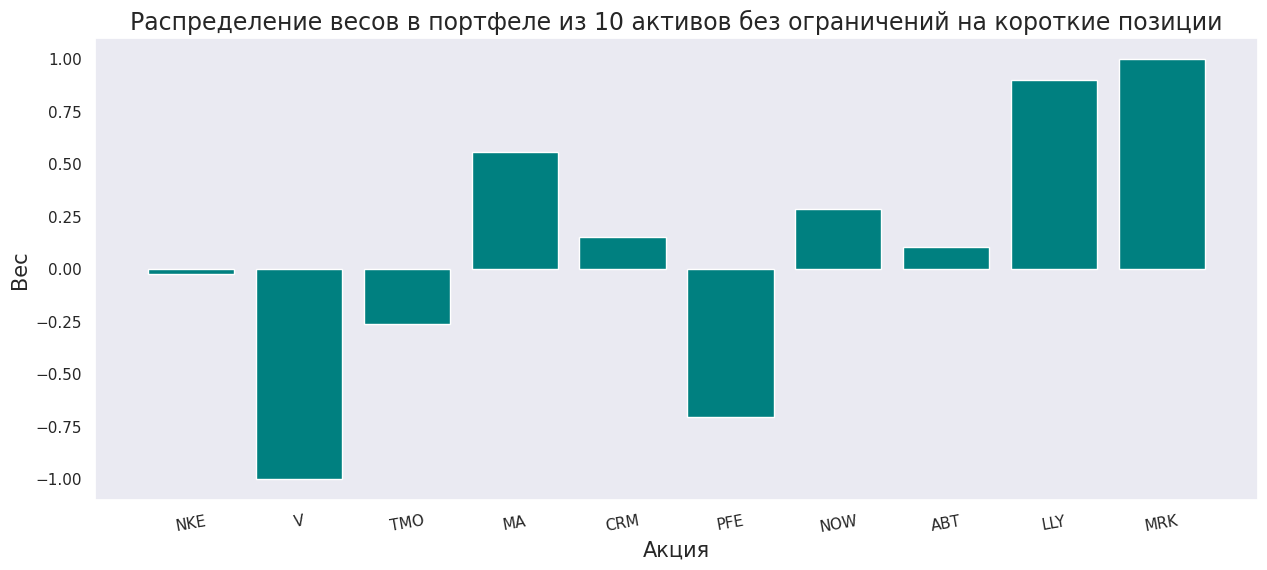

In [43]:
std_short, E_short, loss_short, weights_short = sharp_optimal_portfolio('short', free_risk,sharpes_10, log_profitability_stocks[sharpes_10], profit_10.values,cov_matrix_10)

weights_data = pd.DataFrame(index = sharpes_10, columns = ['weight'])
weights_data['weight'] = weights_short

print(*sorted(dict(weights_data['weight']), key=lambda x: abs(weights_data['weight'][x]), reverse=True))
plt.figure(figsize = (15,6))
x = np.arange(weights_data.shape[0])
x_values = weights_data.index
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(x, height = weights_data['weight'], color="teal")
plt.xticks(x, x_values, rotation=10)
plt.title("Распределение весов в портфеле из 10 активов без ограничений на короткие позиции", fontsize = 17)
plt.grid()

Список компаний в порядке убывания веса в портфеле:

* Visa Inc. - Credit Services
* Merck & Co., Inc. - Drug Manufacturers
* Eli Lilly and Company - Drug Manufacturers
* Pfizer Inc. - Drug Manufacturers
* Mastercard Incorporated - Credit Services
* ServiceNow, Inc. - Software-Application
* Thermo Fisher Scientific Inc. - Diagnostics & Research
* Salesforce, Inc. - Software-Application
* Abbott Laboratories - Medical Devices
* NIKE, Inc. - Footwear & Accessories


Тройка активов из здавоохранения сохранила преимущество (с п.3). Отраслевой состав портфеля не изменился, преобладает сфера здравоохранения, финансовый сектор.

In [40]:
сonfidence_levels = [0.9, 0.95, 0.99]
VaR = {}

print('VaR для портфеля с разрешёнными короткими продажами:')

for level in сonfidence_levels:
    VaR[level] = np.quantile(loss_short, level)
    print('- Потери не превысят %.5f с уверенностью %.f%s.' % (np.round(VaR[level],5), level*100, '%'))

VaR для портфеля с разрешёнными короткими продажами:
- Потери не превысят 0.02010 с уверенностью 90%.
- Потери не превысят 0.02898 с уверенностью 95%.
- Потери не превысят 0.03962 с уверенностью 99%.


**Короткие продажи запрещены**

NKE    2.194271e-17
V      2.043647e-17
TMO    1.132381e-17
MA     0.000000e+00
CRM    0.000000e+00
PFE    0.000000e+00
NOW    1.068400e-01
ABT    0.000000e+00
LLY    3.510955e-01
MRK    5.420645e-01
Name: weight, dtype: float64


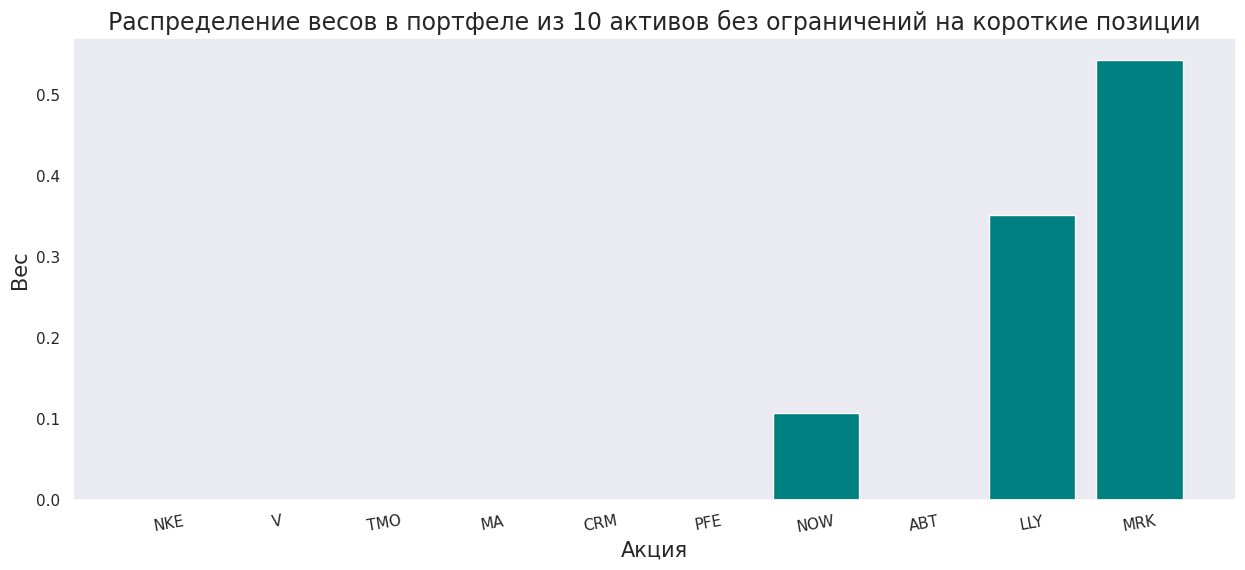

In [44]:
std_short, E_short, loss_short, weights_short = sharp_optimal_portfolio('short_sales_are_not_allowed', free_risk,sharpes_10, log_profitability_stocks[sharpes_10], profit_10.values,cov_matrix_10)

weights_data = pd.DataFrame(index = sharpes_10, columns = ['weight'])
weights_data['weight'] = weights_short

print(weights_data['weight'])
plt.figure(figsize = (15,6))
x = np.arange(weights_data.shape[0])
x_values = weights_data.index
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(x, height = weights_data['weight'], color="teal")
plt.xticks(x, x_values, rotation=10)
plt.title("Распределение весов в портфеле из 10 активов без ограничений на короткие позиции", fontsize = 17)
plt.grid()

При добавлении ограничений на короткие позиции количество активов в портфеле снизилилось до трех. Они совпадают с лидерами в п.3. Паттерн распределения долей инвестиций примерно одинаков

In [42]:
сonfidence_levels = [0.9, 0.95, 0.99]
VaR = {}

print('VaR для портфеля с запретом на короткие продажи:')

for level in сonfidence_levels:
    VaR[level] = np.quantile(loss_short, level)
    print('- Потери не превысят %.5f с уверенностью %.f%s.' % (np.round(VaR[level],5), level*100, '%'))

VaR для портфеля с запретом на короткие продажи:
- Потери не превысят 0.01279 с уверенностью 90%.
- Потери не превысят 0.01884 с уверенностью 95%.
- Потери не превысят 0.03191 с уверенностью 99%.


Можем отметить, что в портфеле с запретом на короткие продажи потери имеют гораздо меньшее значение по сравнению с портфелем с разрешёнными короткими продажами при одних и тех же уровнях значимости

###5. One factor model.
####Рассмотрите набор активов, отобранных в п.2 (10 активов).  Проверьте выполнение условий модели с одним фактором, выбрав в качестве фактора индекс рынка. Считая модель адекватной найдите рыночный портфель для этого набора активов (воспользуйтесь формулой весов оптимального портфеля в модели с одним фактором). Сравните его с портфелем п.4.

In [140]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

def get_AlphaBeta(stock_return, index_return, risk_free = 0): # Create the Alpha vector and Beta matrix

        alpha_vec = []
        beta_mat = []
        stocks_num = stock_return.shape[1]
        reg = LinearRegression()

        for i in range(0, stocks_num):

            reg.fit(np.array(index_return).reshape(len(stock_return), 1),
                    np.array(stock_return.iloc[:, i]).reshape(len(stock_return), 1) -
                    np.array(risk_free * np.ones((len(stock_return), 1))))

            alpha_vec.append(reg.intercept_)
            beta_mat.append(reg.coef_[0,0])

        alpha_vec = np.array(alpha_vec).reshape(stocks_num, 1)
        beta_mat = np.array(beta_mat).reshape(stocks_num, 1)

        return alpha_vec, beta_mat


In [141]:
alpha_vec, beta_mat = get_AlphaBeta(log_profitability_stocks[sharpes_10], log_profitability_nus_index[1:], risk_free=0)

In [142]:
alpha = list(map(lambda x: x[0], alpha_vec))
beta = list(map(lambda x: x[0], beta_mat))
dict_alpha_beta = {'symbol':sharpes_10, 'alpha': alpha, 'beta':beta}
df_alpha_beta = pd.DataFrame(dict_alpha_beta)

df_alpha_beta

,symbol,alpha,beta
0,NKE,0.000759,0.332362
1,V,0.000731,0.356023
2,TMO,0.000716,0.268345
3,MA,0.001016,0.369054
4,CRM,0.001261,0.442388
5,PFE,0.000779,0.217677
6,NOW,0.001512,0.464648
7,ABT,0.000907,0.267341
8,LLY,0.001289,0.162187
9,MRK,0.001264,0.160812


In [143]:
df_comp = pd.DataFrame(columns=[*sharpes_10])
residuals = []

for i, comp in enumerate(sharpes_10):
    comp_res = []
    for idx in log_profitability_nus_index[1:]:
        comp_res.append(df_alpha_beta['alpha'][i] + idx * df_alpha_beta['beta'][i])
    residuals.append(comp_res)


In [145]:
from scipy.stats import ttest_1samp

alpha = 0.05

for idx in range(len(sharpes_10)):
    p_val = ttest_1samp(residuals[idx], 0).pvalue
    print(f'{sharpes_10[idx]}: {p_val < alpha}')

NKE: False
V: False
TMO: False
MA: False
CRM: False
PFE: True
NOW: True
ABT: True
LLY: True
MRK: True


Заметим, что для половины активов гипотеза о нормальности принимается

Выведем шумы, посчитанные для каждого актива

In [174]:
pd.DataFrame(residuals, index = sharpes_10).transpose()

,NKE,V,TMO,MA,CRM,PFE,NOW,ABT,LLY,MRK
0,-0.001723,-0.001927,-0.001288,-0.001740,-0.002042,-0.000847,-0.001957,-0.001089,0.000078,0.000063
1,0.002512,0.002609,0.002132,0.002963,0.003596,0.001927,0.003964,0.002318,0.002144,0.002113
2,0.002600,0.002703,0.002202,0.003060,0.003712,0.001984,0.004086,0.002388,0.002187,0.002155
3,-0.001082,-0.001241,-0.000771,-0.001028,-0.001189,-0.000427,-0.001062,-0.000573,0.000390,0.000373
4,0.002648,0.002755,0.002241,0.003114,0.003776,0.002016,0.004154,0.002427,0.002211,0.002178
...,...,...,...,...,...,...,...,...,...,...
244,-0.009886,-0.010672,-0.007879,-0.010804,-0.012907,-0.006193,-0.013369,-0.007655,-0.003906,-0.003886
245,-0.003396,-0.003720,-0.002639,-0.003598,-0.004269,-0.001943,-0.004296,-0.002435,-0.000739,-0.000746
246,0.020201,0.021557,0.016413,0.022604,0.027139,0.013512,0.028692,0.016546,0.010776,0.010671
247,0.003690,0.003870,0.003082,0.004270,0.005162,0.002698,0.005609,0.003265,0.002719,0.002682


In [173]:
from scipy.stats import pearsonr

alpha = 0.05
cnt = 0
cnt_full = 0

for i in range(len(sharpes_10)):
    for j in range(i + 1, len(sharpes_10)):
        p_val = pearsonr(residuals[i], residuals[j]).pvalue
        if p_val < alpha:
            cnt += 1
        cnt_full += 1

print(f'{cnt}/{cnt_full} шумы активов коррелируют между собой')

2/45 шумы активов коррелируют между собой


Очень малая часть шумов коррелирует между собой, что говорит о независимости данных

### 6. One factor model. Arbitrage.
####Рассмотрите набор активов, отобранных в п.2 (10 активов).  Постройте модель с одним фактором на рынке из этих 10 активов.  Оцените арбитражные возможности на рынке из отобранных 10 активов. Если арбитражные возможности просматриваются, попробуйте построить арбитражный портфель (получить без риска положительный доход из ничего)

In [68]:
dict_alpha_beta = {'alpha': alpha, 'beta':beta}
df_alpha_beta = pd.DataFrame(dict_alpha_beta, index = sharpes_10)
df_alpha_beta

,alpha,beta
NKE,0.000759,0.332362
V,0.000731,0.356023
TMO,0.000716,0.268345
MA,0.001016,0.369054
CRM,0.001261,0.442388
PFE,0.000779,0.217677
NOW,0.001512,0.464648
ABT,0.000907,0.267341
LLY,0.001289,0.162187
MRK,0.001264,0.160812


In [130]:
join_E = []
for i in df_alpha_beta.index:
  l = []
  for j in df_alpha_beta.index:
    if i!=j:
      curr_E = (float(df_alpha_beta.loc[[i]].alpha) * float(df_alpha_beta.loc[[j]].beta) - \
      float(df_alpha_beta.loc[[j]].alpha) * float(df_alpha_beta.loc[[i]].beta))\
      / (float(df_alpha_beta.loc[[i]].beta) - float(df_alpha_beta.loc[[j]].beta))
      l.append(curr_E)
    else:
      l.append(0)
  join_E.append(l)

Построим таблицу с доходностями каждой пары активов

In [89]:
arb = pd.DataFrame(join_E, index = df_alpha_beta.index, columns = df_alpha_beta.index)
arb

,NKE,V,TMO,MA,CRM,PFE,NOW,ABT,LLY,MRK
NKE,0.000000,-0.001152,-0.000535,0.001571,0.000760,-0.000816,0.001134,-0.001518,-0.001794,-0.001738
V,-0.001152,0.000000,-0.000670,0.007059,0.001456,-0.000854,0.001830,-0.001440,-0.001756,-0.001703
TMO,-0.000535,-0.000670,0.000000,0.000084,0.000126,-0.001049,0.000373,-0.051936,-0.002164,-0.002084
MA,0.001571,0.007059,0.000084,0.000000,0.000219,-0.000437,0.000900,-0.000622,-0.001503,-0.001456
CRM,0.000760,0.001456,0.000126,0.000219,0.000000,-0.000311,0.003723,-0.000367,-0.001305,-0.001266
PFE,-0.000816,-0.000854,-0.001049,-0.000437,-0.000311,0.000000,-0.000132,-0.000214,-0.002780,-0.002637
NOW,0.001134,0.001830,0.000373,0.000900,0.003723,-0.000132,0.000000,-0.000088,-0.001169,-0.001133
ABT,-0.001518,-0.001440,-0.051936,-0.000622,-0.000367,-0.000214,-0.000088,0.000000,-0.001877,-0.001803
LLY,-0.001794,-0.001756,-0.002164,-0.001503,-0.001305,-0.002780,-0.001169,-0.001877,0.000000,0.001610
MRK,-0.001738,-0.001703,-0.002084,-0.001456,-0.001266,-0.002637,-0.001133,-0.001803,0.001610,0.000000


<Axes: >

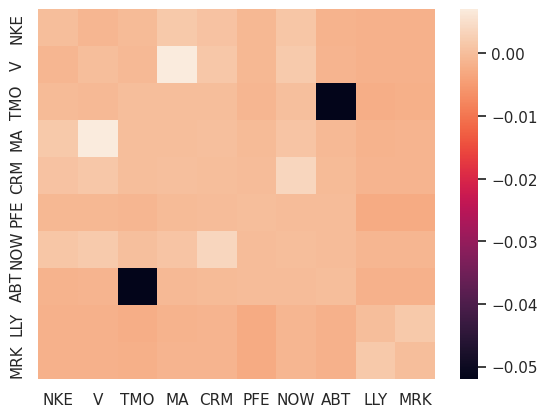

In [90]:
sns.heatmap(arb)

После подсчёта доходностей каждой пары акций заметим арбитражные возможности портфеля, состоящего из акций TMO и ABT, так как их доходность наиболее отклонена от нуля

TMO - Thermo Fisher Scientific (американский производитель научного оборудования)

ABT - Abbott Laboratories (американская химико-фармацевтическая корпорация)

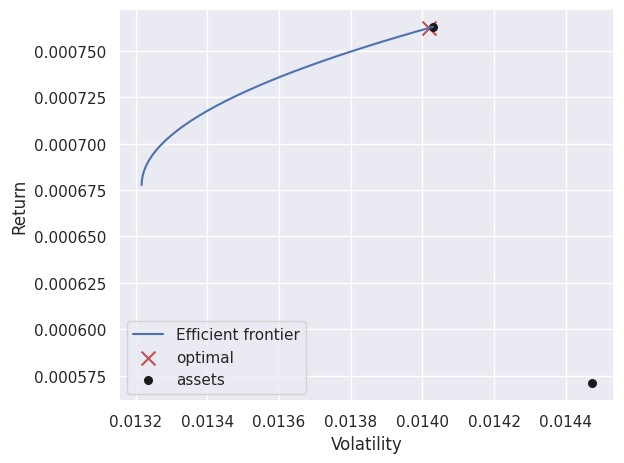

In [127]:
arbitrage_stocks = ['TMO', 'ABT']
cov_matrix_arbitrage = log_profitability_stocks[arbitrage_stocks].cov()
cl_obj = CLA(profit_10[arbitrage_stocks], cov_matrix_arbitrage)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False, verbose = True)

Вес TMO - 0.002907295589077827
Вес ABT - 0.9970927044109222


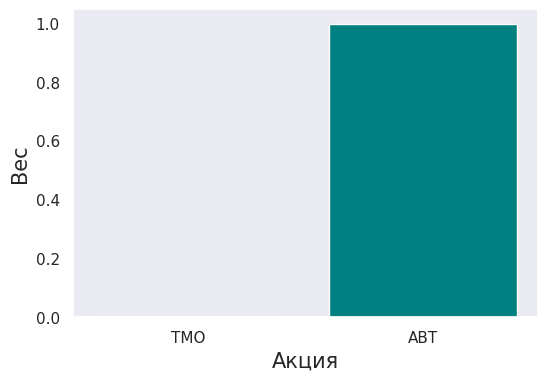

In [129]:
print(f'Вес TMO - {cl_obj.weights[0]}')
print(f'Вес ABT - {cl_obj.weights[1]}')

plt.figure(figsize = (6,4))
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(arbitrage_stocks, height = cl_obj.weights, color="teal")
plt.grid()

Эффективный портфель был составлен с использованием алгоритма критической линии, реализованного Маркосом Лопесом де Прадо и Дэвидом Бейли. Обратим внимание на то, что в данном портфеле акции ABT берутся практически в полном объёме в отличие от TMO